# Convolutional Neurale Netværk med Keras
I den næste kode blok er der kodet et simpelt convolutional neurale netværk (CNN) til at genkende håndskreven cifre ved bruge af MNSIT datasætet.

## Importering
Her importerer vi de pakker vi skal bruge. Vi bruger:
- numpy til nogle matematik og vektor operation
- matplotlib til at vise billeder og plots
- torch til at lave alt ML
- Hjælpe træning og testing funktioner fra vores lokal sti

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from CNN_utils.train import train
from CNN_utils.test import test


## Datasæt importering
Heldigvis kan man overfør MNIST datasætet ved bruge af et funktion fra torch. Her overfører vi træning og testing datasætene, og så splitter vi træning sættet videre til træning og validereng sæt.

In [2]:
# Denne transform funktion gives til datasættet for at billederne kommer ud i den rigtig format, som er matricer med værdier mellem 0 og 1.
# Vi normalisere pixlerne fra [0, 255] til [0, 1] fordi mest ML algoritmer er bygget til at arbejde bedst med normaliseret data.
def image_transform(img):
    return torchvision.transforms.ToTensor()(img).unsqueeze(0)

# Overfører CIFAR10 træning og test datasætene fra pytorch
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=image_transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=image_transform)

# Splitter træning sætet til en træning og validering sæt.
# val_set_ratio bestemmer hvor meget af sættet bliver brugt til validering.
val_set_ratio = 0.1
train_set, val_set = random_split(train_set, [int(len(train_set)*(1-val_set_ratio)), int(len(train_set)*val_set_ratio)])

# Tjekker størrelsen af billederne og hvor mange klasser der er
print("Images shape:", train_set[0][0].shape)
print("Number of classes:", len(np.unique(test_set.targets)))

# Model / data parameter
num_classes = 10
input_shape = (1, 28, 28)

Images shape: torch.Size([1, 1, 28, 28])
Number of classes: 10


In [3]:
# Laver dataloadere der samler vores data i batches og shuffler dem hvis vi vil gerne
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Vi laver en løkke igennem datasætet og viser et billede fra hvert klasse. Vi kan finde hvad for noget klasser der er fra datasættets hjemmeside [her](https://www.cs.toronto.edu/~kriz/cifar.html)

/tmp/ipykernel_19991/2435488914.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  Fig.show()


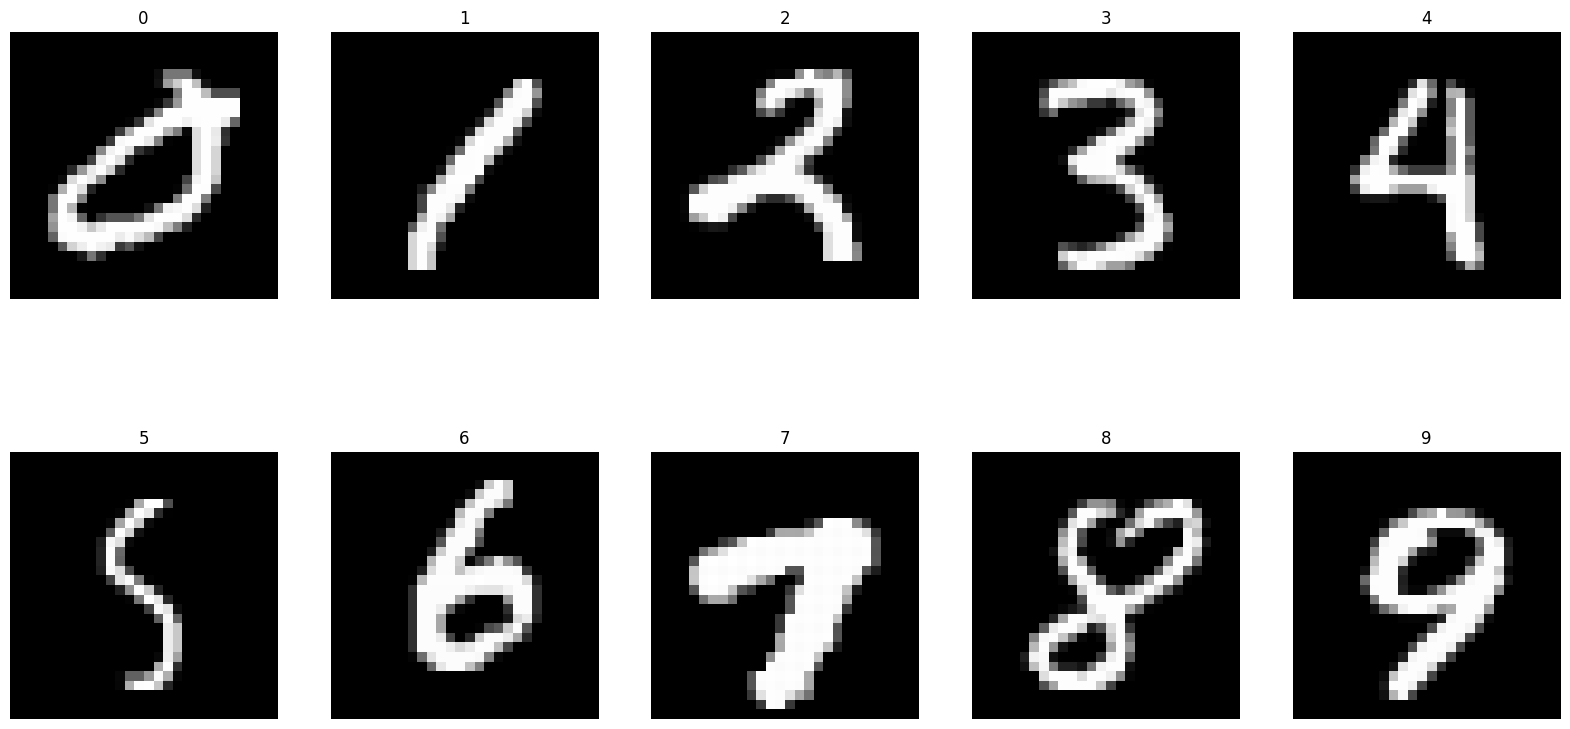

In [4]:
Fig, ax = plt.subplots(2, 5, figsize=(20, 10))
label_to_print = 0
for imgs, labels in train_loader:
    for img, label in zip(imgs, labels):
        if label == label_to_print:
            ax[label_to_print // 5, label_to_print % 5].imshow(img[0].permute(1,2,0), cmap="gray")
            ax[label_to_print // 5, label_to_print % 5].axis("off")
            ax[label_to_print // 5, label_to_print % 5].set_title(label_to_print)
            label_to_print += 1
        if label_to_print == num_classes:
            break
Fig.show()

## Model initialisering
Derafter laver vi CNN modelen som vi skal træne til at genkende objekterne. Her specificerer vores model class som hedder Net. Der er der to vigtige metoder:

Den første er \_\_init\_\_, som initialiserer modellen. Her initialiserer vi også alle de lag og moduler vi vil gerne bruge i modellen, som er:
- nn.Conv2d, som er en convolutional lag. De fire argumenter vi giver den er: [Input kanaler, Output kanaler, størrelsen af kernen, antal steps kernen tager (stride)]
- nn.Dropout, som tilfældigt vælger en procentdel af neuroneren og deaktiverer dem under træning. Denne model bruges til at undgå overfitting, og gør det at modellen lærer at bruge alle sine vægte. Den virker kun under træning og dens ene argument er procentdelen af neuroner der skal deaktiveres.
- nn.Linear er et almideligt neural netværk lag, den tager som argumenter: [Antal input neuroner, Antal output neuroner].

Den anden er forward, som præcis beskriver hvad der sker med billedene der kommer igennem netværket og i hvilket order. I vorse funktion sker dette:

conv1 -> RELU -> conv2 -> RELU -> MaxPool2D -> dropout1 -> flatten -> fc1 -> RELU -> dropout2 -> fc2 -> softmax

Hvor RELU og softmax er aktivering funktionerne, og flatten er en funktion der konverterer billederne til en vektor. Her bruger vi os MaxPool2D, men den blivet ikke initaliseret i \_\_init\_\_. Der er fordi MaxPool2D er en funktion, og ikke en lag der har vægter der skal trænes, så man behøver ikke initialiserer før man bruger den.

Man kan nemt tilføje eller fjern lag og moduler fra netværket. Hvis den lag du vil gerne bruge har trænerbar vægter, så husk at initialiserer den under et variable før du bruger den under forward funktionen. Hvis du vil gerne bruge en funktion uden vægter, så kan du bare sætte den hvor den skal være i forward funktionen.

Vores model har også 2 variable man kan ændre sidste i \_\_init\_\_ funktionen som ændrer træning processen. Man kan vælge loss funktion og optimering algoritme, lige nu bruges der CrossEntropyLoss, og SGD optimizer.

De 3 argumenter under \_\_init\_\_ funktionen er dem man skal give når man først initialiserer modelen. Den første er en dictionary af hyperparameter der kan bruges under træning, disse kan være antal epochs, og optimering algoritmens learning rate. Et eksemple af model initialisering kan ses i den næste blok.

In [5]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder
    
    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch
    
    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, hyperparameters: dict = {}, input_shape = (1, 28, 28), num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(input_shape[0], 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Input størrelsen er følgende: (Antal output kanaler af conv2*((billedets højde minus 4 på grund af de 2 convolutions)/2 på grund af maxpool2D)*Det samme men med billedets bredde)
        self.fc1 = nn.Linear(64*((self.input_shape[1]-4)//2)*((self.input_shape[2]-4)//2), 128)
        self.fc2 = nn.Linear(128, num_classes)  

        # Vælg loss function og optimizer
        self.criterion = nn.CrossEntropyLoss
        self.optimizer = optim.SGD
        self.hyperparameters = hyperparameters

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket
        
        Args:
        x (torch.Tensor): Input tensor
        
        Returns:
        torch.Tensor: Output tensor
        """
        x = x.reshape([-1] + list(self.input_shape))
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def predict(self, x: np.ndarray):
        """
        Forudsig klasse
        
        Args:
        x (np.ndarray): Input data
        
        Returns:
        torch.Tensor: Forudsiget klasse
        """
        # Konverter til tensor
        x = torch.Tensor(x).float()
        x = x.reshape([-1] + list(self.input_shape))

        # Forudsig klasse
        y_hat_prob = self(x)
        y_hat = torch.argmax(y_hat_prob, dim=1)

        return y_hat.detach().numpy()[0], y_hat_prob[0].detach().numpy()

Her initialiserer vi modelen med en hyperparameter, vi siger at modelen skal træne for 15 epochs. De to andre er "lr" og "momentum". Vi også indsætter billede størrelsen og antal klasser som vi har fundet før.

In [6]:
model = Net({"epochs": 5, "lr": 0.001}, input_shape=input_shape, num_classes=num_classes)

# Træning af modellen
Før vi træner modellen er det en god ide at starte en mlflow server for at dokumentere hvordan vores model udvikler sig under træning. Det kan man gør ved at åbne en terminal og skrive:

```
mlflow server
```

ind i den. Luk ikke terminal, ellers slukker mlflow serveren. Du kan spørge en af arrangørene for hjælp med at sætte den op.

Nu bruger vi træning funktionen fra hjælpe scripten. Den tage de to træning og validering dataloaders, og burger dem til at træne den model vi giver til den. Den kan tage lidt tid at være færdig med at træne modellen.

In [7]:
train(train_loader, val_loader, model)

[0 / 5 29.502s] Training: Loss: 0.575982 Accuracy: 0.791667 | Validation: Loss: 0.203440 Accuracy: 0.937500
[1 / 5 32.376s] Training: Loss: 0.345529 Accuracy: 0.875000 | Validation: Loss: 0.247394 Accuracy: 0.895833
[2 / 5 29.980s] Training: Loss: 0.148036 Accuracy: 0.979167 | Validation: Loss: 0.132482 Accuracy: 0.979167
[3 / 5 27.989s] Training: Loss: 0.698160 Accuracy: 0.833333 | Validation: Loss: 0.337254 Accuracy: 0.958333
[4 / 5 32.406s] Training: Loss: 0.079585 Accuracy: 0.979167 | Validation: Loss: 0.176053 Accuracy: 0.937500


## Testing af Vores Model
Til sidst bruger vi test funktionen fra hjælpe scriptet og de 10 tusind test billeder fra test datasætet til at evaluerer hvor god vores trænet model er til at klassifikerer billeder den har ikke set før.

In [8]:
test(test_loader, model)

Test accuracy: 0.9611862897872925


In [10]:
class Net(nn.Module):
    """
    Netværksarkitektur for klassifikation af billeder
    
    Args:
    nn.Module: Superklasse for alle neurale netværk i PyTorch
    
    Returns:
    Net: Netværksarkitektur
    """
    def __init__(self, hyperparameters: dict = {}, input_shape = (1, 28, 28), num_classes: int = 3):
        # Initialiserer architecturen
        super(Net, self).__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(input_shape[0], 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Input størrelsen er følgende: (Antal output kanaler af conv2*((billedets højde minus 4 på grund af de 2 convolutions)/2 på grund af maxpool2D)*Det samme men med billedets bredde)
        self.fc1 = nn.Linear(64*((((self.input_shape[1]-2)//2)-2)//2)*((((self.input_shape[1]-2)//2)-2)//2), 128)
        self.fc2 = nn.Linear(128, num_classes)  

        # Vælg loss function og optimizer
        self.criterion = nn.CrossEntropyLoss
        self.optimizer = optim.SGD
        self.hyperparameters = hyperparameters

    def forward(self, x: torch.Tensor):
        """
        Forward pass af netværket
        
        Args:
        x (torch.Tensor): Input tensor
        
        Returns:
        torch.Tensor: Output tensor
        """
        x = x.reshape([-1] + list(self.input_shape))
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output
    
    def predict(self, x: np.ndarray):
        """
        Forudsig klasse
        
        Args:
        x (np.ndarray): Input data
        
        Returns:
        torch.Tensor: Forudsiget klasse
        """
        # Konverter til tensor
        x = torch.Tensor(x).float()
        x = x.reshape([-1] + list(self.input_shape))

        # Forudsig klasse
        y_hat_prob = self(x)
        y_hat = torch.argmax(y_hat_prob, dim=1)

        return y_hat.detach().numpy()[0], y_hat_prob[0].detach().numpy()
    
model = Net({"epochs": 5}, input_shape=input_shape, num_classes=num_classes)
train(train_loader, val_loader, model)

[0 / 5 11.361s] Training: Loss: 2.299063 Accuracy: 0.333333 | Validation: Loss: 2.301142 Accuracy: 0.208333
[1 / 5 19.114s] Training: Loss: 2.292081 Accuracy: 0.437500 | Validation: Loss: 2.291688 Accuracy: 0.416667
[2 / 5 18.475s] Training: Loss: 2.269307 Accuracy: 0.187500 | Validation: Loss: 2.281779 Accuracy: 0.208333
[3 / 5 12.544s] Training: Loss: 1.947257 Accuracy: 0.562500 | Validation: Loss: 1.902445 Accuracy: 0.604167
[4 / 5 11.217s] Training: Loss: 1.795076 Accuracy: 0.687500 | Validation: Loss: 1.813666 Accuracy: 0.666667


In [ ]:
test(test_loader, model)

Test accuracy: 0.9481489062309265


# Opgaver

Experimentering opgaver findes i Playground_CNN.ipynb.